In [ ]:
# Import basic libs and analysis/visualization modules
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# analysis helper (module created) and visualization helper (existing)
from src.analysis import analysis as anl
from src.visualization import visualization as viz

# Choose experiment base directory (latest experiment mentioned)
BASE_DIR = 'runs/fashion_cv_l1_dropoutLows_l2'

# find a sample activations file to inspect
sample = glob.glob(os.path.join(BASE_DIR, '*', 'fold*', 'activations_collected.csv'))
if not sample:
    sample = glob.glob(os.path.join('runs', '*', '*', 'fold*', 'activations_collected.csv'))
sample_file = sample[0] if sample else None
print('sample file:', sample_file)
if sample_file:
    df = pd.read_csv(sample_file)
    print('columns:', df.columns.tolist())
    print('shape:', df.shape)
else:
    print('No activations file found under', BASE_DIR)


(8399, 64)

In [ ]:
# Inspect a single activations file and separate labels from activations
if sample_file is None:
    raise RuntimeError('No sample activations file found; run previous cell to set BASE_DIR correctly')
df = pd.read_csv(sample_file)
# detect label columns (pred_label / true_label) and separate them if present
label_cols = [c for c in ['pred_label', 'true_label'] if c in df.columns]
if label_cols:
    labels = df[label_cols].copy()
    Xdf = df.drop(columns=label_cols)
else:
    labels = None
    Xdf = df
X = Xdf.values

# Count unique states (rounding approach). Adjust decimals to control tolerance.
n_states, reps = anl.count_unique_states_rounding(X, decimals=4, normalize_l2=True)
print("Número de unique states (rounding):", n_states)

# As a comparison, compute nearest-neighbor distances among representatives
if reps.shape[0] > 1:
    nn = anl.nearest_neighbor_distances(reps, k=1)
    print("NN dist (rep median):", float(np.median(nn)))
else:
    print('Not enough representatives to compute NN distances')

# Quick label-based diagnostics if labels present
if labels is not None:
    print('Label columns found:', labels.columns.tolist())
    if 'pred_label' in labels.columns and 'true_label' in labels.columns:
        acc = (labels['pred_label'] == labels['true_label']).mean()
        print(f'accuracy in file: {acc:.4f}')
        import sklearn.metrics as skm
        cm = skm.confusion_matrix(labels['true_label'], labels['pred_label'])
        print('confusion matrix shape:', cm.shape)


Número de unique states (rounding): 198
NN dist (rep median): 0.10000000000000005


In [ ]:
# Full run over the parameter folder using the module's helpers (now handling labels)
import os
import glob
from tqdm import tqdm

BASE_DIR = 'runs/fashion_cv_l1_dropoutLows_l2'
EPS = 0.15  # label only; counting uses decimals parameter

def count_from_folder(act_file, decimals=4):
    df = pd.read_csv(act_file)
    # separate label columns if present
    label_cols = [c for c in ['pred_label', 'true_label'] if c in df.columns]
    if label_cols:
        Xdf = df.drop(columns=label_cols)
        labels = df[label_cols].copy()
    else:
        Xdf = df
        labels = None
    X = Xdf.values
    n, reps = anl.count_unique_states_rounding(X, decimals=decimals, normalize_l2=True)
    med_nn = None
    if reps.shape[0] > 1:
        med_nn = float(np.median(anl.nearest_neighbor_distances(reps, k=1)))
    # compute accuracy from labels if available
    file_acc = None
    if labels is not None and 'pred_label' in labels.columns and 'true_label' in labels.columns:
        file_acc = float((labels['pred_label'] == labels['true_label']).mean())
    return n, med_nn, file_acc

results = []
param_dirs = sorted(glob.glob(os.path.join(BASE_DIR, '*')))
for param_dir in tqdm(param_dirs, desc='Parámetros'):
    param_name = os.path.basename(param_dir)
    if not os.path.isdir(param_dir):
        continue
    fold_dirs = sorted(glob.glob(os.path.join(param_dir, 'fold*')))
    for fold_dir in tqdm(fold_dirs, desc=f'Folds {param_name}', leave=False):
        act_file = os.path.join(fold_dir, 'activations_collected.csv')
        met_file = os.path.join(fold_dir, 'metrics.csv')
        if not (os.path.exists(act_file) and os.path.exists(met_file)):
            continue
        n_states, med_nn, file_acc = count_from_folder(act_file, decimals=4)
        metrics = pd.read_csv(met_file)
        last = metrics.iloc[-1]
        train_acc = float(last['train_acc'])
        val_acc = float(last['val_acc'])
        results.append({
            'param': param_name,
            'fold': os.path.basename(fold_dir),
            'num_states': int(n_states),
            'med_nn_dist': med_nn,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'file_acc': file_acc
        })

results_df = pd.DataFrame(results)
results_df.head()

Parámetros: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]



,param,fold,num_states,med_nn_dist,train_acc,val_acc
0,baseline,fold1,8277,0.168273,0.877679,0.865476
1,baseline,fold2,7903,0.141756,0.874018,0.848333
2,baseline,fold3,8139,0.140436,0.876577,0.842381
3,baseline,fold4,8261,0.181718,0.882113,0.859643
4,baseline,fold5,8112,0.155953,0.871905,0.860238


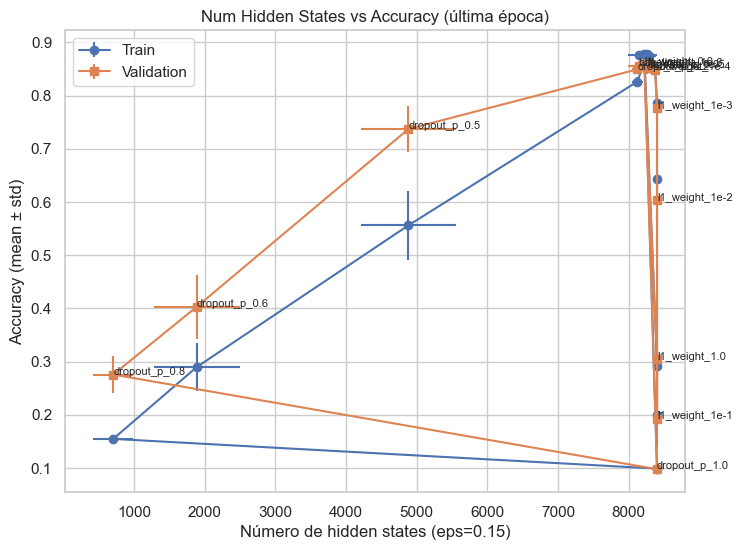

In [ ]:
# Aggregate and plot using the module helpers
agg = anl.pretty_summary(results_df, state_col='num_states', train_col='train_acc', val_col='val_acc')
ax = anl.plot_states_vs_accuracy(agg, eps=EPS)
plt.show()
# show an extra scatter: file_acc vs num_states (if file_acc available)
if 'file_acc' in results_df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(results_df['num_states'], results_df['file_acc'])
    plt.xlabel('num_states')
    plt.ylabel('file accuracy (from saved preds)')
    plt.title('Num states vs file accuracy')
    plt.grid(True)
    plt.show()

In [ ]:
# Correlate num_states with overfitting
corr = anl.correlate_with_overfitting(results_df, state_col='num_states', train_col='train_acc', val_col='val_acc')
print('Pearson r:', corr['pearson_r'], 'p:', corr['pearson_p'])
print('Spearman r:', corr['spearman_r'], 'p:', corr['spearman_p'])
corr['df'].head()
# also show correlation between num_states and file-level accuracy (if available)
if 'file_acc' in results_df.columns:
    import scipy.stats as st
    mask = results_df['file_acc'].notnull()
    if mask.sum() > 1:
        r, p = st.pearsonr(results_df.loc[mask,'num_states'], results_df.loc[mask,'file_acc'])
        print('Pearson num_states vs file_acc:', r, p)


Pearson r: 0.7881467108225663 p: 4.805295070334517e-17
Spearman r: 0.4359711006304498 p: 9.24072948544476e-05


,param,fold,num_states,med_nn_dist,train_acc,val_acc,overfit
0,baseline,fold1,8277,0.168273,0.877679,0.865476,0.012202
1,baseline,fold2,7903,0.141756,0.874018,0.848333,0.025685
2,baseline,fold3,8139,0.140436,0.876577,0.842381,0.034196
3,baseline,fold4,8261,0.181718,0.882113,0.859643,0.022470
4,baseline,fold5,8112,0.155953,0.871905,0.860238,0.011667


In [ ]:
# Run visualization module to create per-run metrics plots (PNG/HTML)
cfg = {'trainer': {'out_dir': BASE_DIR}}
viz.run_visualization(cfg)


In [ ]:
# Analyze correct vs incorrect activations if label columns are present in sample file
if sample_file and ('pred_label' in df.columns and 'true_label' in df.columns):
    lab = df[['pred_label','true_label']].copy()
    Xdf = df.drop(columns=['pred_label','true_label'])
    X = Xdf.values
    correct_mask = (lab['pred_label'] == lab['true_label']).values
    print('overall accuracy (from activations file):', correct_mask.mean())
    # per-class stats
    classes = np.unique(lab['true_label'])
    per_class = []
    from scipy.spatial.distance import euclidean
    for c in classes:
        mask_true = (lab['true_label'] == c).values
        correct = X[mask_true & correct_mask]
        incorrect = X[mask_true & (~correct_mask)]
        mean_correct = correct.mean(axis=0) if len(correct)>0 else np.zeros(X.shape[1])
        mean_incorrect = incorrect.mean(axis=0) if len(incorrect)>0 else np.zeros(X.shape[1])
        dist = float(np.linalg.norm(mean_correct-mean_incorrect)) if (len(correct)>0 and len(incorrect)>0) else np.nan
        per_class.append({'class': int(c), 'n_true': int(mask_true.sum()), 'n_correct': int((mask_true & correct_mask).sum()), 'n_incorrect': int((mask_true & (~correct_mask)).sum()), 'mean_dist_correct_incorrect': dist})
    per_class_df = pd.DataFrame(per_class)
    display(per_class_df.sort_values('mean_dist_correct_incorrect', na_position='last'))
else:
    print('No label columns present in sample file; cannot compute correct/incorrect analysis')
